In [ ]:

from langchain_core.runnables import RunnableLambda
from fastapi import FastAPI, Request
from pydantic import BaseModel
from typing import List
from langchain_core.messages import get_buffer_string
from langchain_core.runnables import RunnableConfig
from langchain_core.prompts import ChatPromptTemplate
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_qdrant import QdrantVectorStore
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage, FunctionMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_ollama import OllamaEmbeddings
from qdrant_client import QdrantClient

from langgraph.prebuilt import ToolNode
from langgraph.graph import  END, START, MessagesState, StateGraph
from langgraph.checkpoint.memory import InMemorySaver
from IPython.display import Image, display

# Import necessary tools
from tools.memory import save_recall_memories, search_recall_memories
from tools.rag import vectorstore_collection_init, vectorstore_add_documents
from tools.llm import llm_chat_tool, llm_call
from tools.web_search import web_search_tool

import os
import requests
from dotenv import load_dotenv
load_dotenv()

# Initialize LangSmith project
os.environ["LANGSMITH_PROJECT"] = 'tg-bot'

QDRANT_URL = os.getenv("QDRANT_URL")
LLM_API_SERVER_URL = os.getenv("LLM_API_SERVER_URL")
# LLM_MODEL_NAME = os.getenv("LLM_MODEL_NAME")

# Initialize Qdrant client
client_qd = QdrantClient(url=QDRANT_URL)



class State(MessagesState):
    messages: List[BaseMessage]

In [2]:
emb_model_name = '../../../models/multilingual-e5-large-instruct'
embeddings = HuggingFaceEmbeddings(model_name=emb_model_name)

LLM_MODEL_NAME='qwen3:0.6b'

llm = ChatOpenAI(
    model=LLM_MODEL_NAME,
    openai_api_base=LLM_API_SERVER_URL,
    api_key="EMPTY",  # required by LangChain, but not used by Ollama
    temperature=0.2,
    max_tokens=200
)


In [3]:
tools = [save_recall_memories, search_recall_memories, web_search_tool]
llm_with_tools = llm.bind_tools(tools)

In [ ]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("""
            'system_message'
            You are a helpful assistant. Use long-term, recall memory and retrieval tools internally to inform your answers.
            If the user asks simple, general knowledge or factual questions (e.g., "What is the capital of France?"), answer immediately and directly without consulting external memory or tools.
            Do not explain your internal thoughts. Only respond to the user's questions clearly and concisely.
            You must rely on external tools and memory systems  to store information between conversations. You can also perform Retrieval-Augmented
            Generation (RAG) to access relevant knowledge in real-time.
            Use the guidelines below to engage with the user.

         
            ## MEMORY USAGE GUIDELINES
            
            1. Actively use memory tools to build a 
            comprehensive understanding of the user.
            2. Make informed suppositions and extrapolations based on stored memories.
            3. Regularly reflect on past interactions to identify patterns and preferences.
            4. Update your mental model of the user with each new piece of information.
            5. Cross-reference new information with existing memories for consistency.
            6. Store emotional context and personal values alongside factual information.
            7. Use memory to anticipate needs and tailor responses to the user’s style.
            8. Recognize and acknowledge changes in the user's situation or perspective.
            9. Leverage memories to provide personalized examples and analogies.
            10. Recall past challenges or successes to inform current problem-solving.

            
            ## RAG USAGE GUIDELINES
            
            - Use RAG every time you do internet search to get some external information.
            - Use RAG when you need up-to-date, domain-specific, or context-specific information
            - Use RAG to retrieve relevant documents or data that can enhance the conversation.
            - Use RAG to provide accurate and timely responses to user queries.
            - Use RAG to access a wide range of user conversation history.

            
            ## RECALL MEMORIES GUIDELINES
            
            Recall memories are contextually retrieved based on the current conversation:
            {recall_memories}

            ## INSTRUCTIONS
           
            Engage with the user naturally, as a trusted colleague or friend. 
            Do not explicitly mention your memory or retrieval capabilities. 
            Instead, seamlessly integrate them into your responses. 
            Be attentive to subtle cues and underlying emotions. 
            Adapt your communication style to match the user's preferences and current emotional state. 
            If you use tools, call them internally and respond only after the tool operation 
            completes successfully. 
        """),
        ("placeholder", "{messages}"),
    ]
)


In [12]:
def load_memories(state: State, config: RunnableConfig) -> State:
    """Load memories for the current conversation.

    Args:
        state (schemas.State): The current state of the conversation.
        config (RunnableConfig): The runtime configuration for the agent.

    Returns:
        State: The updated state with loaded memories.
    """
    # add long-term memory search in future    
    
    search_recall_memories_runnable = RunnableLambda(search_recall_memories)

    conv_str = get_buffer_string(state["messages"][-3:]) # get all messages in the conversation or change to 2-3
    # conv_str = tokenizer.decode(tokenizer.encode(conv_str)[-2048:]) # tokenize last messages and limit to 2048 tokens
    recall_memories = search_recall_memories_runnable.invoke(conv_str, config)
    return {
        "messages": recall_memories,
    }


def agent(state: State) -> State:
    """Process the current state and generate a response using the LLM.

    Args:
        state (schemas.State): The current state of the conversation.

    Returns:
        schemas.State: The updated state with the agent's response.
    """
    bound = prompt | llm_with_tools
    # recall_str = (
    #     "<recall_memory>\n" + "\n".join(state["messages"]) + "\n</recall_memory>"
    # )

    recall_str = (
        "<recall_memory>\n" +
        "\n".join(
            m.content for m in state["messages"] 
            if hasattr(m, "content") and not isinstance(m, ToolMessage)
        ) + 
        "\n</recall_memory>"
    )

    prediction = bound.invoke(
        {
            "messages": state["messages"],
            "recall_memories": recall_str,
        }
    )

    # save the response in the long-term memory in the future
    # vectorstore_add_documents(
    #     client_qd=client_qd,
    #     collection_name='long_term_memory',
    #     documents=[Document(page_content=prediction.content)],
    #     embeddings=embeddings
    # )
    return {
        "messages": [prediction],
    }

def route_tools(state: State):
    """Determine whether to use tools or end the conversation based on the last message.

    Args:
        state (schemas.State): The current state of the conversation.

    Returns:
        Literal["tools", "__end__"]: The next step in the graph.
    """
    msg = state["messages"][-1]
    if msg.tool_calls:
        return "tools"

    return END

In [13]:
def build_agent():
    builder = StateGraph(State)

    builder.add_node(load_memories)
    builder.add_node(agent)
    builder.add_node("tools", ToolNode(tools))

    builder.add_edge(START, "load_memories")
    builder.add_edge("load_memories", "agent")
    builder.add_conditional_edges("agent", route_tools, ["tools", END])
    builder.add_edge("tools", "agent")

    memory = InMemorySaver()
  
    return builder.compile(checkpointer=memory)

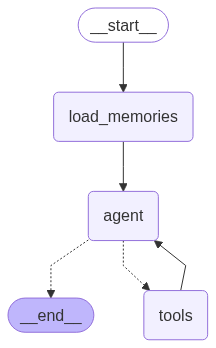

In [14]:
graph = build_agent()
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
def pretty_print_stream_chunk(chunk):
    """Pretty print the stream chunk."""
    for node, updates in chunk.items():
        print(f"Update from node: {node}")
        if "messages" in updates:
            if updates["messages"]:  # check not empty
                updates["messages"][-1].pretty_print()
            else:
                print("<No messages in updates>")
        else:
            print(updates)

        print("\n")

# load from  backend
user_id = '123'
thread_id = '456'

# def chat_with_agent(user_input: str) -> str:
#     """Interact with the agent using a user input string.

#     Args:
#         user_input (str): The input string from the user.

#     Returns:
#         str: The agent's response.
#     """
#     config = {"configurable": {"user_id": user_id, "thread_id": thread_id}}
#     for chunk in graph.stream({"messages": [("user", user_input)]}, config=config):
#         pretty_print_stream_chunk(chunk)
        
#     return chunk.get("agent").get("messages")[-1].content

In [ ]:
def chat_with_agent(user_input: str, user_id: int, thread_id: int) -> str:
    """Send a user input string to the agent and return the agent's final response."""
    config = {"configurable": {"user_id": user_id, "thread_id": thread_id}}

    # Prepare the initial messages list with a HumanMessage object
    initial_messages: List[BaseMessage] = [HumanMessage(content=user_input)]

    final_chunk = None
    for chunk in graph.stream({"messages": initial_messages}, config=config):
        pretty_print_stream_chunk(chunk)
        final_chunk = chunk

    # Extract the last agent message content safely
    agent_node = final_chunk.get("agent")
    if not agent_node or "messages" not in agent_node or not agent_node["messages"]:
        raise RuntimeError("No agent messages found in the response chunk.")

    last_msg = agent_node["messages"][-1]
    # last_msg should be a BaseMessage
    return last_msg.content

In [17]:
query = "What is the capital of France?"
response = chat_with_agent(query)
print(f"Agent response: {response}")

Update from node: load_memories
<No messages in updates>


Update from node: agent
================================== Ai Message ==================================

<think>
Okay, let's see. The user is asking a question, and I need to use the tools provided. First, I should check if they need a simple answer or if they want more information. The user's message is just a single question, so I should respond directly without using any tools unless it's a general knowledge question. Wait, but the user hasn't provided a specific question yet. Oh, right, the initial message is just the system message. Wait, no, the user's input is the system message. Wait, no, the user's message is the system message. Wait, no, looking back, the user's input is the system message. Wait, no, the user's message is the system message. Wait, maybe I'm misunderstanding. Let me check again.

The user's message is the system message. So, the user is telling me to act as a helpful assistant following the guidelines

In [ ]:
from fastapi import FastAPI, Request
from pydantic import BaseModel
# from langgraph_agent import build_agent

app = FastAPI()
agent = build_agent()

class UserInput(BaseModel):
    message: str
    user_id: str  # Optional: for multi-user memory
    thread_id: str  # Optional: for multi-user memory

@app.post("/chat")
def chat(user_input: UserInput):
    state = {
        "input": user_input.message,
        "user_id": user_input.user_id,
        "thread_id": user_input.thread_id
    }
    result = agent.invoke(state)
    return {"response": result.get("input", "Sorry, something went wrong.")}